In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve

from librosa.core import stft
from librosa.core import istft
from librosa import amplitude_to_db, db_to_amplitude
from librosa.display import specshow
from librosa.output import write_wav

from scipy.signal import butter, lfilter, csd
from scipy.linalg import svd, pinv

from utils import apply_reverb, read_wav
import corpus
import mir_eval

import pyroomacoustics as pra

(-1, 9)

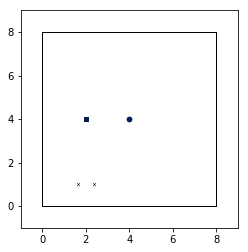

In [4]:
corners = np.array([[0,0], [0,8], [8,8], [8,0]]).T  # [x,y]
room = pra.Room.from_corners(corners)

# s1, s2 = map(read_wav, corpus.experiment_files_timit())
s1, s2 = map(read_wav, ["/home/tinus/Workspace/corpus/TIMIT/TRAIN/DR5/FGMB0/SI1775.WAV","/home/tinus/Workspace/corpus/TIMIT/TRAIN/DR5/FGMB0/SA2.WAV"])

if len(s1) > len(s2):
    pad_length = len(s1) - len(s2)
    s2 = np.pad(s2, (0,pad_length), 'reflect')
else:
    pad_length = len(s2) - len(s1)
    s1 = np.pad(s1, (0,pad_length), 'reflect')

room.add_source([4.,4.], signal=s1)
room.add_source([2.,4.], signal=s2)

R = pra.linear_2D_array(center=[2.,1.], M=2, phi=0, d=0.75)
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

fig, ax = room.plot()
ax.set_xlim([-1, 9])
ax.set_ylim([-1, 9])

3D case

(0, 6)

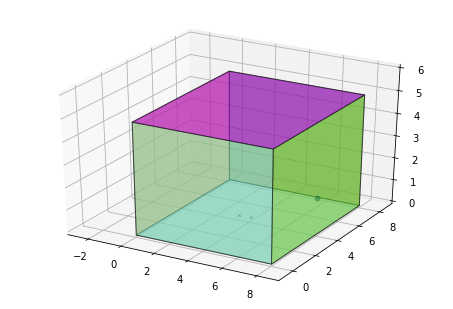

In [5]:
corners = np.array([[0,0], [0,8], [8,8], [8,0]]).T  # [x,y]
room = pra.Room.from_corners(corners)
room.extrude(5.)

# s1, s2 = map(read_wav, corpus.experiment_files_timit())
s1, s2 = map(read_wav, ["/home/tinus/Workspace/corpus/TIMIT/TRAIN/DR5/FGMB0/SI1775.WAV","/home/tinus/Workspace/corpus/TIMIT/TRAIN/DR5/FGMB0/SA2.WAV"])

if len(s1) > len(s2):
    pad_length = len(s1) - len(s2)
    s2 = np.pad(s2, (0,pad_length), 'reflect')
else:
    pad_length = len(s2) - len(s1)
    s1 = np.pad(s1, (0,pad_length), 'reflect')

room.add_source([8.,4.,1.6], signal=s1)
# room.add_source([2.,4.,1.6], signal=s2)
#[[X],[Y],[Z]]
R = np.asarray([[4.75,5.5],[2.,2.],[1.,1]])
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))
    
fig, ax = room.plot()
ax.set_xlim([-3, 9])
ax.set_ylim([-1, 9])
ax.set_zlim([0, 6])

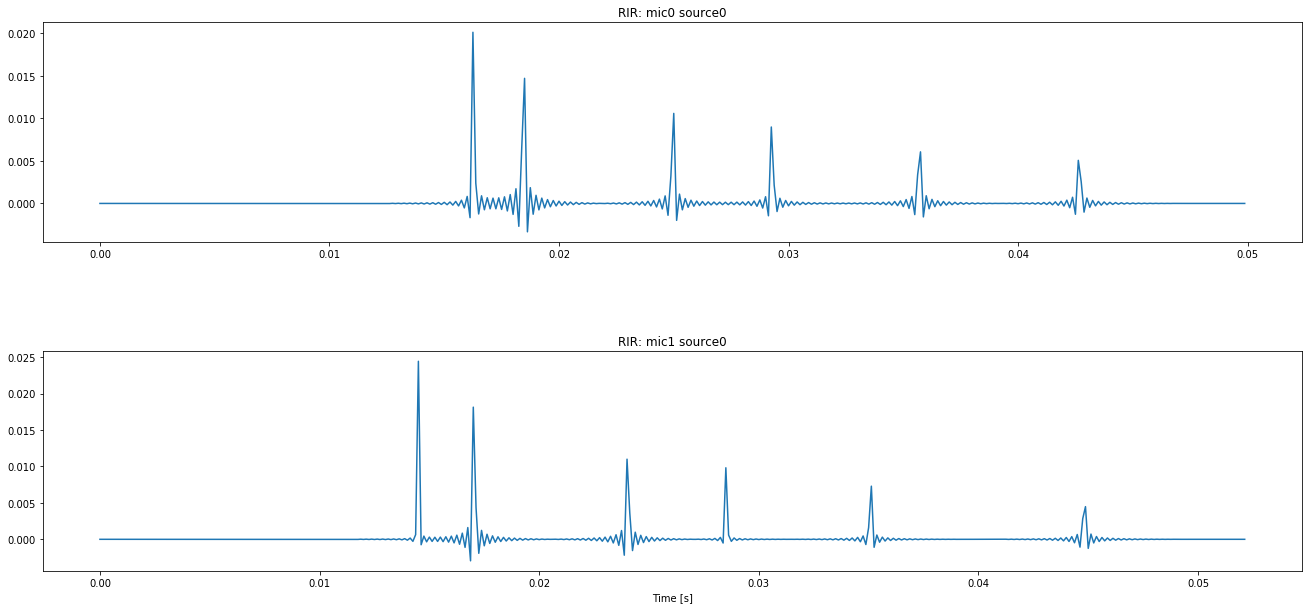

In [6]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)

In [7]:
room.simulate()
print(room.mic_array.signals.shape)

(2, 51208)


In [8]:
nfft=2048
win = 1024
hop = int(nfft/8)

Y1 = stft(room.mic_array.signals[0], n_fft=nfft, hop_length=hop, win_length=win)
Y2 = stft(room.mic_array.signals[1], n_fft=nfft, hop_length=hop, win_length=win)

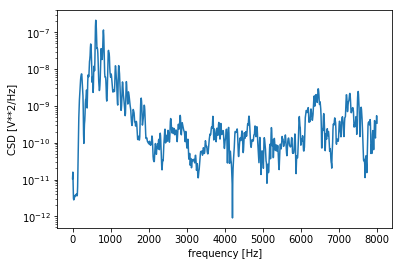

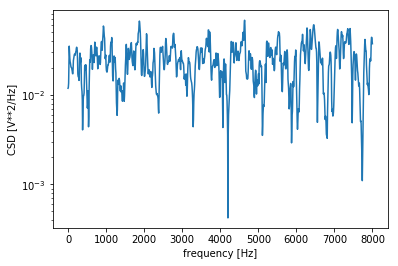

In [9]:

f, Pxy = csd(s1, room.mic_array.signals[0], 16000, nperseg=win, nfft=nfft, noverlap=hop)
_, Pxx = csd(s1, s1, 16000, nperseg=win, nfft=nfft, noverlap=hop)
plt.semilogy(f, np.abs(Pxy))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

H1 = np.divide(Pxy, Pxx)
plt.semilogy(f, np.abs(H1))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

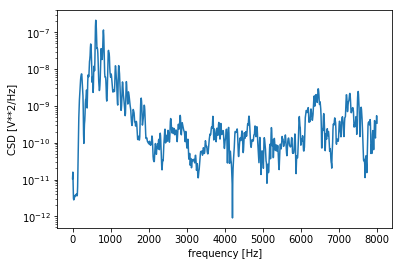

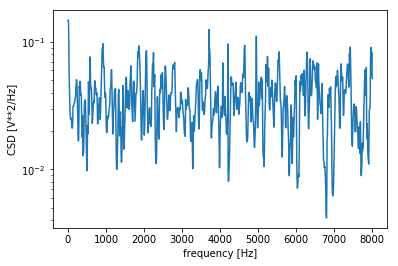

In [10]:
f, Pyx = csd(room.mic_array.signals[0], s1, 16000, nperseg=win, nfft=nfft, noverlap=hop)
_, Pyy = csd(room.mic_array.signals[0], room.mic_array.signals[0], 16000, nperseg=win, nfft=nfft, noverlap=hop)
plt.semilogy(f, np.abs(Pyx))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

H1 = np.divide(Pyy, Pyx)
plt.semilogy(f, np.abs(H1))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

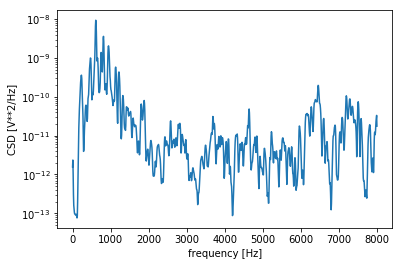

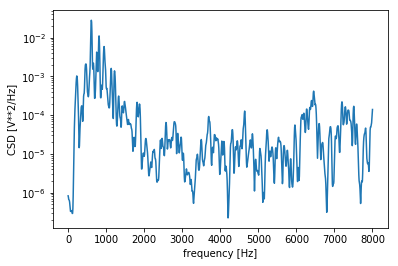

In [11]:
f, Pyy = csd(room.mic_array.signals[0], room.mic_array.signals[0], 16000, nperseg=win, nfft=nfft, noverlap=hop)
plt.semilogy(f, np.abs(Pyy))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

PSD = np.conj(Y1)*Y1
plt.semilogy(f, np.abs(np.mean(PSD,axis=1)))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

(1025, 199)
(1025, 199)
(1025, 199)
(1025, 199)


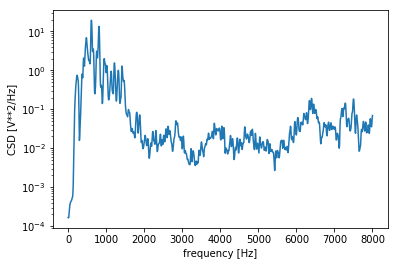

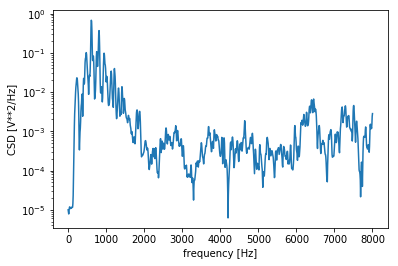

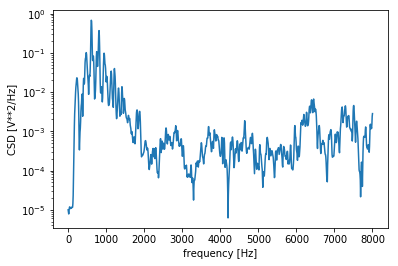

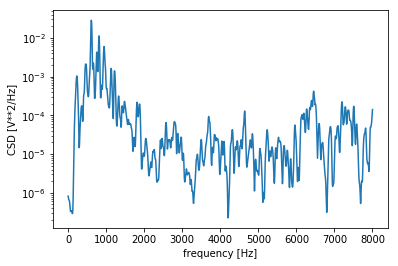

In [12]:
nfft=2048
win = 1024
hop = int(nfft/8)
Y1 = stft(room.mic_array.signals[0,:len(s1)], n_fft=nfft, hop_length=hop, win_length=win)
X1 = stft(s1, n_fft=nfft, hop_length=hop, win_length=win)

Gxx = X1 * np.conj(X1)
Gxy = X1 * np.conj(Y1)
Gyx = Y1 * np.conj(X1)
Gyy = Y1 * np.conj(Y1)

print(Gxx.shape)
print(Gxy.shape)
print(Gyx.shape)
print(Gyy.shape)

plt.semilogy(f, np.abs(np.mean(Gxx,axis=1)))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

plt.semilogy(f, np.abs(np.mean(Gxy,axis=1)))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

plt.semilogy(f, np.abs(np.mean(Gyx,axis=1)))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

plt.semilogy(f, np.abs(np.mean(Gyy,axis=1)))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

(2050, 398)
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140]),)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 

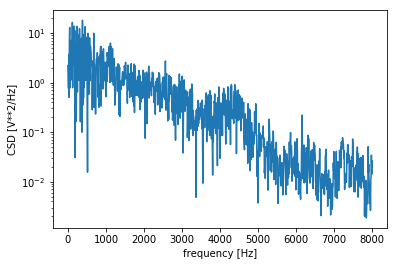

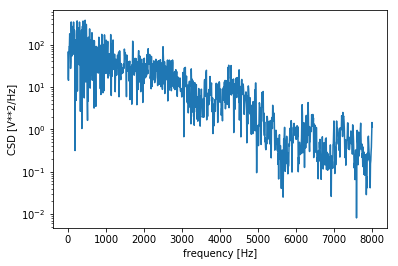

In [16]:
from scipy.linalg import svd, pinv

F, T = Gxx.shape

temp = np.asarray([[Gxx, Gxy],[Gyx, Gyy]]).reshape(F*2,T*2)

print(temp.shape)
U, s, V = svd(temp)
print(np.where(s>1))
print(np.where(s>10))
print(U.shape)
print(V.shape)
smallUgt1 = U[np.where(s>1),:].reshape(-1, F*2).T
smallUgt10 = U[np.where(s>0.5),:].reshape(-1, F*2).T
smallVgt1 = V[np.where(s>1),:].reshape(-1, T*2)
smallVgt10 = V[np.where(s>0.5),:].reshape(-1, T*2)

# Hsgt1 = np.mean(np.matmul(smallUgt1,pinv(smallVgt1).T), axis=1)
# Hsgt10 = np.mean(np.matmul(smallUgt10,pinv(smallVgt10).T), axis=1)

Hsgt1_avg = np.mean(np.matmul(smallUgt1[:F,:],pinv(smallVgt1[:,T:]).T), axis=1)
Hsgt10_avg = np.mean(np.matmul(smallUgt10[:F,:],pinv(smallVgt10[:,T:]).T), axis=1)

Hsgt1 = np.matmul(smallUgt1[:F,:],pinv(smallVgt1[:,T:]).T)
Hsgt10 = np.matmul(smallUgt10[:F,:],pinv(smallVgt10[:,T:]).T)

print(Hsgt1.shape)

plt.semilogy(f, np.abs(Hsgt1_avg[:F].reshape(-1,)))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()
# plt.semilogy(f, np.abs(Hsgt1[1025:].reshape(-1,)))
# plt.xlabel('frequency [Hz]')
# plt.ylabel('CSD [V**2/Hz]')
# plt.show()

plt.semilogy(f, np.abs(Hsgt10_avg[:1025].reshape(-1,)))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()
# plt.semilogy(f, np.abs(Hsgt10[1025:].reshape(-1,)))
# plt.xlabel('frequency [Hz]')
# plt.ylabel('CSD [V**2/Hz]')
# plt.show()

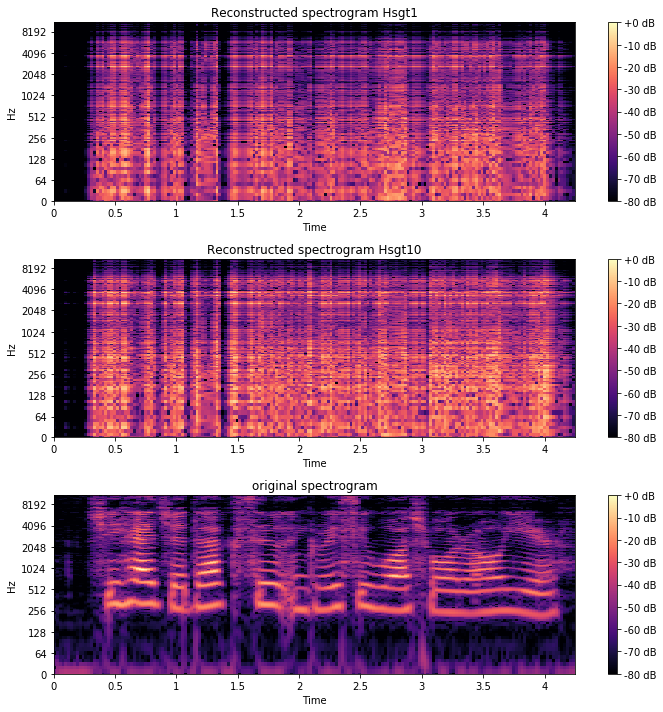

In [20]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(311)
specshow(amplitude_to_db(Hsgt1, ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram Hsgt1')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
ax1 = plt.subplot(312)
specshow(amplitude_to_db(Hsgt10, ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram Hsgt10')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.subplot(313, sharex=ax1)
specshow(amplitude_to_db(Y1, ref=np.max), y_axis='log', x_axis='time')
plt.title('original spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

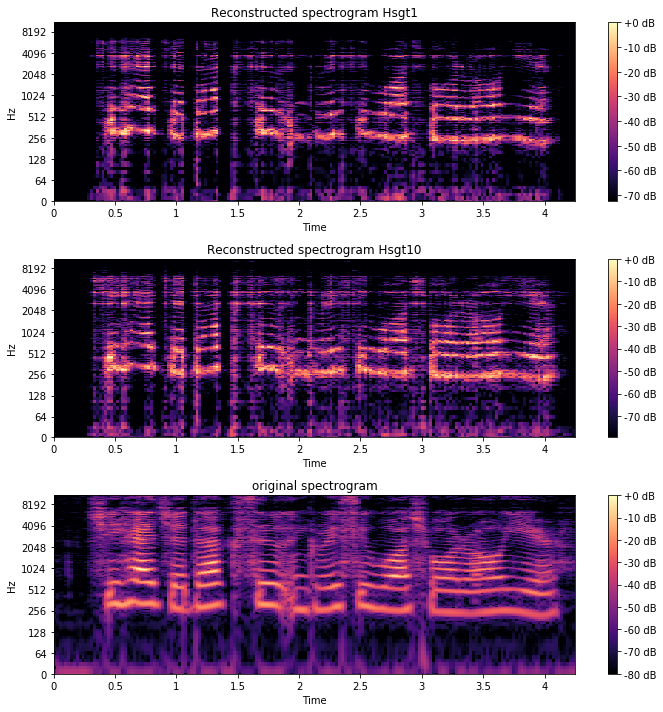

In [21]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(311)
specshow(amplitude_to_db(np.multiply(Hsgt1,Y1), ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram Hsgt1')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
ax1 = plt.subplot(312)
specshow(amplitude_to_db(np.multiply(Hsgt10,Y1), ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram Hsgt10')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.subplot(313, sharex=ax1)
specshow(amplitude_to_db(Y1, ref=np.max), y_axis='log', x_axis='time')
plt.title('original spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

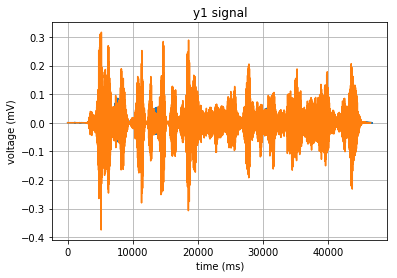

In [22]:
recon_y1_Hsgt1 = istft(np.multiply(Hsgt1,Y1), hop_length=hop, win_length=win) * 2000
recon_y1_Hsgt10 = istft(np.multiply(Hsgt10,Y1), hop_length=hop, win_length=win) * 2000

fig, ax = plt.subplots()
ax.plot(s1)
ax.plot(recon_y1_Hsgt10)


ax.set(xlabel='time (ms)', ylabel='voltage (mV)',
       title='y1 signal')
ax.grid()


# write_wav('removed_reverb_Hsgt1.wav', recon_y1_Hsgt1, 16000)
# write_wav('removed_reverb_Hsgt10.wav', recon_y1_Hsgt10, 16000)